In [19]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
sns.set_palette("rocket")

In [20]:
df = pd.read_csv("seattle-weather.csv",index_col="date",parse_dates=True)
df_temp = df["temp_max"]

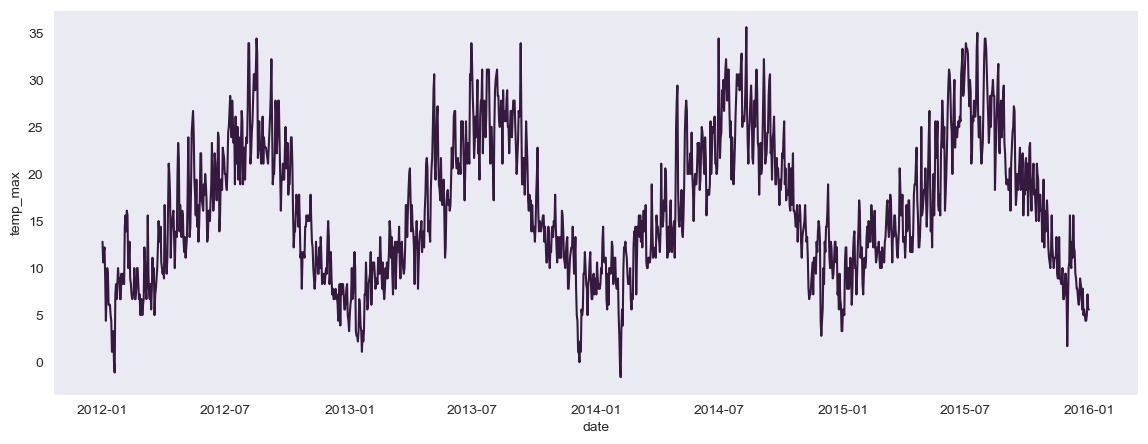

In [21]:
plt.figure(figsize=(14,5))
sns.lineplot(df_temp);

In [22]:
def df_to_XY(df,window_size=10):
    df_np = df_temp.to_numpy()
    X = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [[a] for a in df_np[i:i+window_size]]
        X.append(row)
        target = df_np[i+window_size]
        y.append(target)
    return np.array(X),np.array(y)

In [23]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

1451 1451


In [24]:
X.shape

(1451, 10, 1)

#### Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback


In [26]:
model = Sequential()
model.add(LSTM(64,input_shape=(WINDOW,1)))
model.add(Dense(32,"relu"))
model.add(Dropout(0.2))
model.add(Dense(16,"relu"))
model.add(Dense(1,"linear"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


In [30]:
callback1 = ModelCheckpoint('model/', save_best_only=True)
earlyStopping = EarlyStopping(monitor="val_root_mean_squared_error", patience=3, restore_best_weights=True)

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [31]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, callbacks=[earlyStopping])

Epoch 1/100
25/25 [==============================] - 10s 96ms/step - loss: 269.9250 - root_mean_squared_error: 16.4294 - val_loss: 480.9203 - val_root_mean_squared_error: 21.9299
Epoch 2/100
25/25 [==============================] - 0s 16ms/step - loss: 257.2424 - root_mean_squared_error: 16.0388 - val_loss: 456.5409 - val_root_mean_squared_error: 21.3668
Epoch 3/100
25/25 [==============================] - 0s 17ms/step - loss: 238.8698 - root_mean_squared_error: 15.4554 - val_loss: 428.6002 - val_root_mean_squared_error: 20.7027
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 220.4568 - root_mean_squared_error: 14.8478 - val_loss: 399.4862 - val_root_mean_squared_error: 19.9872
Epoch 5/100
25/25 [==============================] - 0s 17ms/step - loss: 201.0205 - root_mean_squared_error: 14.1782 - val_loss: 371.2101 - val_root_mean_squared_error: 19.2668
Epoch 6/100
25/25 [==============================] - 0s 19ms/step - loss: 182.2187 - root_mean_squared_error:

25/25 [==============================] - 0s 17ms/step - loss: 13.8122 - root_mean_squared_error: 3.7165 - val_loss: 13.0143 - val_root_mean_squared_error: 3.6075
Epoch 48/100
25/25 [==============================] - 0s 16ms/step - loss: 14.7200 - root_mean_squared_error: 3.8367 - val_loss: 13.7985 - val_root_mean_squared_error: 3.7146
Epoch 49/100
25/25 [==============================] - 0s 17ms/step - loss: 13.3580 - root_mean_squared_error: 3.6549 - val_loss: 13.3982 - val_root_mean_squared_error: 3.6604
Epoch 50/100
25/25 [==============================] - 0s 17ms/step - loss: 14.2048 - root_mean_squared_error: 3.7689 - val_loss: 12.6483 - val_root_mean_squared_error: 3.5564
Epoch 51/100
25/25 [==============================] - 0s 17ms/step - loss: 14.7797 - root_mean_squared_error: 3.8444 - val_loss: 13.2956 - val_root_mean_squared_error: 3.6463
Epoch 52/100
25/25 [==============================] - 0s 16ms/step - loss: 14.6345 - root_mean_squared_error: 3.8255 - val_loss: 13.2198 -

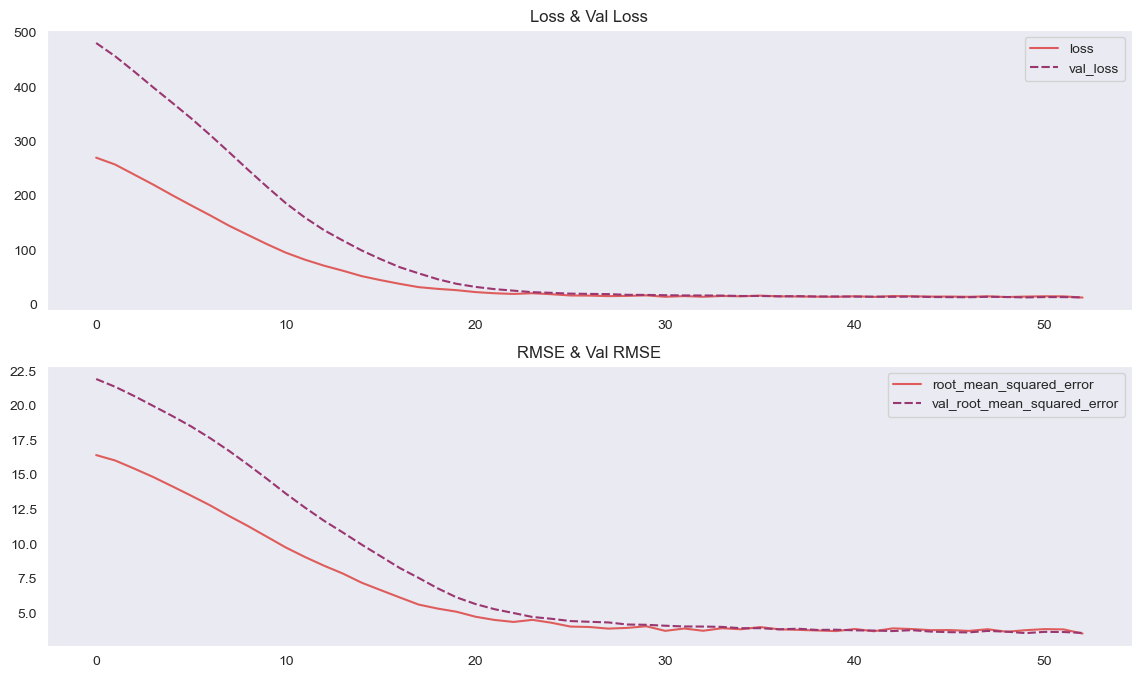

In [32]:
his = pd.DataFrame(history.history)
his.columns
history_loss = his[['loss', 'val_loss']]
history_rmse =  his[['root_mean_squared_error', 'val_root_mean_squared_error']]

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

plt.subplot(2,1,2)
plt.title("RMSE & Val RMSE")
sns.lineplot(history_rmse,palette="flare");

#### Evaluation

In [33]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 9ms/step


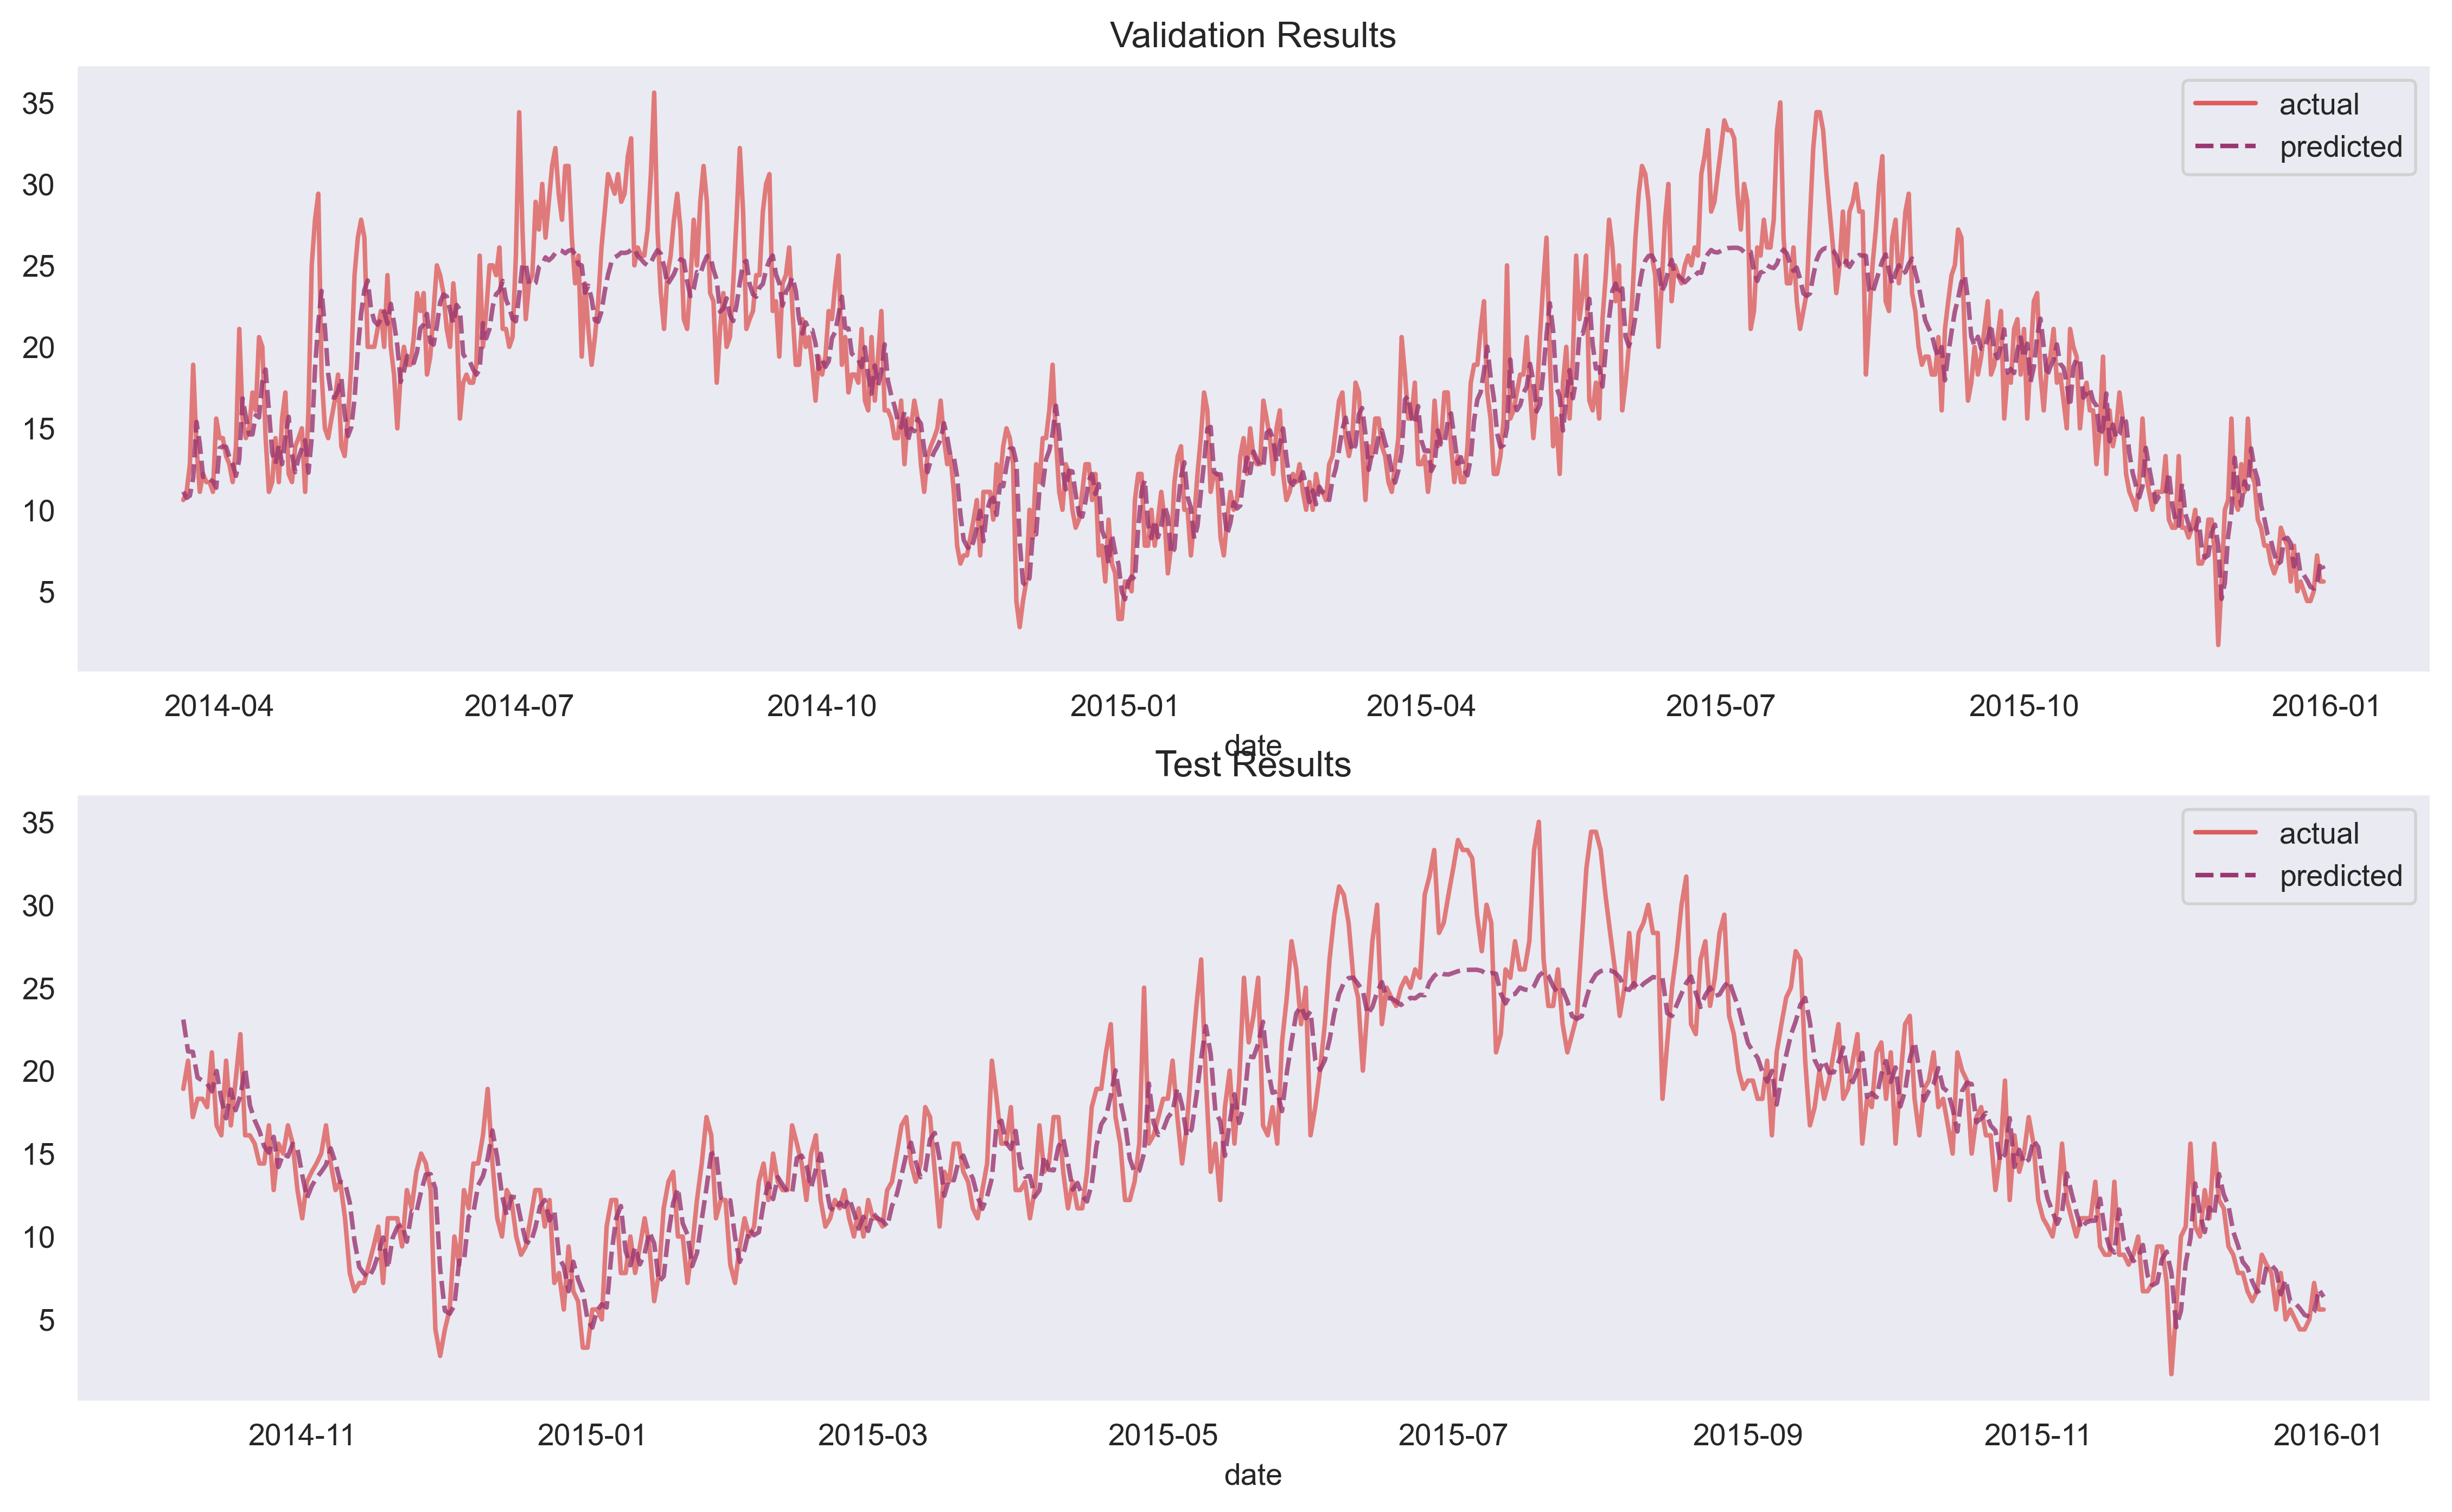

In [34]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);

In [37]:
test_pred

array([23.080502 , 21.160688 , 21.131342 , 19.583733 , 19.402205 ,
       19.219086 , 18.75249  , 19.977386 , 18.257313 , 17.12853  ,
       18.859634 , 17.615622 , 18.48663  , 20.14955  , 17.908102 ,
       17.016235 , 16.367815 , 15.434951 , 15.052757 , 16.005835 ,
       14.192361 , 14.98258  , 14.824509 , 15.584236 , 15.281727 ,
       13.715967 , 12.307201 , 13.039324 , 13.532528 , 13.89471  ,
       14.315124 , 15.312365 , 14.436275 , 13.2882595, 13.232435 ,
       12.030862 ,  9.7290325,  8.154218 ,  7.7596498,  7.5279303,
        8.070913 ,  8.913081 ,  9.939318 ,  8.070158 ,  9.907814 ,
       10.566672 , 10.739649 ,  9.689501 , 11.501418 , 11.448096 ,
       12.719014 , 13.741022 , 13.759276 , 12.888088 ,  8.043976 ,
        5.5257254,  5.345349 ,  5.8402524,  8.546021 ,  8.49552  ,
       11.197189 , 11.476985 , 13.09181  , 13.637863 , 14.703402 ,
       16.389784 , 14.754328 , 12.501026 , 11.252417 , 12.399162 ,
       12.3526325, 10.954271 ,  9.732564 ,  9.572836 , 10.5266

In [39]:
predictions = model.predict(X_test)

15/15 [==============================] - 0s 8ms/step
